<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/01_foundations/W4_MAs_Final_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Moving Average Crossing Strategy

In this script I would like to analyze whicha re the performance of a simle trading strategy based on crossing moving averages. Differently from what we have done in the other analysis we will position ourselves on a shorter time frame

## Data and Libraries Importing

In [1]:
#importing main libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

## Functions for Data Processing

1. generate_signals(df, short_window, long_window): Adds shortEMA, longEMA, and position columns. Last position forced to 0 to close open trades.

2. compute_strategy_returns(df, slippage_pct, transaction_cost_pct, risk_free_rate): Uses position column to:

- Apply slippage and transaction costs.

- Inject the risk-free return when out of market.

- Compute the strategy return: final_strategy_return.

- Adds cumulative_strategy and cumulative_bnh.

3. strategy_metrics(df) Uses final_strategy_return as input return stream. It Calculates:

- Sharpe ratio

- Max Drawdown

- CAGR

- Number of Trades

- Win Rate

- Wins / Losses

In [2]:
def simple_strategy(df, short_window, long_window):
    df = df.copy()[['close', 'volume']]

    df['shortEMA'] = df['close'].rolling(window=short_window).mean()
    df['longEMA'] = df['close'].rolling(window=long_window).mean()

    df.dropna(inplace=True)

    df['position'] = (df['shortEMA'] > df['longEMA']).astype(int)
    df.iloc[-1, df.columns.get_loc('position')] = 0  # Force exit

    return df

In [50]:
def volume_filter(df, short_window, long_window):
    df = df.copy()[['close', 'volume']]

    df['shortEMA'] = df['close'].rolling(window=short_window).mean()
    df['longEMA'] = df['close'].rolling(window=long_window).mean()
    df['avg_volume'] = df['volume'].rolling(window=20).mean()

    df.dropna(inplace=True)  # drop NaNs *after all indicators created*

    df['volume_filter'] = df['volume'] > df['avg_volume']
    df['position'] = ((df['shortEMA'] > df['longEMA']) & df['volume_filter']==True).astype(int)
    df.iloc[-1, df.columns.get_loc('position')] = 0  # Force exit

    return df

In [ ]:
#creating the function to calculate the strategy returns
def compute_strategy_returns(df, slippage_pct, transaction_cost_pct):
    """
    Computes strategy returns given a position column, accounting for slippage, transaction costs, and risk-free rate.

    Parameters:
    - df: DataFrame with 'Close' and 'position' columns
    - slippage_pct: Slippage cost as a percentage (e.g., 0.002 for 0.2%)
    - transaction_cost_pct: Transaction cost per trade (e.g., 0.005 for 0.5%)
    - risk_free_rate: Daily return of risk-free asset (e.g., 0.0002)

    Returns:
    - df: DataFrame with added columns for strategy return and cumulative return
    """

    df = df.copy()
    df['daily_return'] = df['close'].squeeze().pct_change()

    df['position_change'] = df['position'].diff().fillna(0).ne(0).astype(int)
    df['slippage_flag'] = df['position_change']
    df['close_with_slippage'] = df['close'].squeeze() * (1 + slippage_pct * df['slippage_flag'])

    df['return_with_slippage'] = df['close_with_slippage'].pct_change() * df['position'].shift(1)
    df['transaction_cost'] = transaction_cost_pct * df['position_change']
    df['strategy_return_with_costs'] = df['return_with_slippage'] - df['transaction_cost']

    df['final_strategy_return'] = df['strategy_return_with_costs']

    df['cumulative_bnh'] = (1 + df['daily_return']).cumprod()

    df['cumulative_strategy'] = (1 + df['final_strategy_return']).cumprod()

    return df


In [ ]:
def generate_trade_log(df):
    trade_log = []
    entry_date = None
    entry_price = None

    for i in range(1, len(df)):
        if df['position'].iloc[i-1] == 0 and df['position'].iloc[i] == 1:
            # Trade Entry
            entry_date = df.index[i]
            entry_price = df['close'].iloc[i]

        elif df['position'].iloc[i-1] == 1 and df['position'].iloc[i] == 0:
            # Trade Exit
            exit_date = df.index[i]
            exit_price = df['close'].iloc[i]

            if entry_date is not None and entry_price is not None:
                trade_return = (exit_price / entry_price) - 1
                trade_log.append({
                    'Entry Date': entry_date,
                    'Entry Price': entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'Trade Return': trade_return
                })

            # Reset
            entry_date = None
            entry_price = None

    return pd.DataFrame(trade_log)


In [ ]:
def strategy_metrics(df):
    """
    Calculate key strategy metrics: Sharpe ratio, max drawdown, CAGR, win rate, and number of trades.

    Parameters:
    - df: DataFrame with strategy returns and other related data.

    Returns:
    - metrics: Dictionary containing key strategy metrics.
    """

    #calculate the total return (cumulative return)
    total_return = df['cumulative_strategy'].iloc[-1] - 1
    #calculate the maximum drawdown
    cumulative_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    #Calculate the Sharpe ratio (annualized)
    daily_sharpe = df['final_strategy_return'].mean() / df['final_strategy_return'].std()
    annualized_sharpe = daily_sharpe * np.sqrt(252)
    # Compound Annual Growth Rate (CAGR)
    start_value = df['cumulative_strategy'].iloc[0]
    end_value = df['cumulative_strategy'].iloc[-1]
    years = (df.index[-1] - df.index[0]).days / 252
    cagr = (end_value / start_value) ** (1 / years) - 1
    #number of trades (position changes from 0 to 1 and 1 to 0)
    df['trade_signal'] = df['position'].diff().ne(0).astype(int)  # 1 when position changes
    num_trades = df['trade_signal'].sum()

     # 6. Count winning trades
    winning_trades = 0
    trade_start_price = None
    for i in range(1, len(df)):
        # Trade starts when position changes from 0 to 1 (buy)
        if df['trade_signal'].iloc[i] == 1 and df['position'].iloc[i] == 1:
            trade_start_price = df['close'].iloc[i].item()
        #ends when position changes from 1 to 0 (sell)
        elif df['trade_signal'].iloc[i] == 1 and df['position'].iloc[i] == 0:
            if trade_start_price is not None and df['close'].iloc[i].item() > trade_start_price:
                winning_trades += 1
            trade_start_price = None

    #Calculate the win rate (winning trades / total trades)
    win_rate = winning_trades / num_trades if num_trades != 0 else 0

    #all the metrics in a dictionary
    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'annualized_sharpe': annualized_sharpe,
        'cagr': cagr,
        'num_trades': num_trades,
        'winning_trades': winning_trades,
        'win_rate': win_rate
    }

    return metrics


## Base Strategy

In [18]:
#defining the period of analysis
period = '2y'
#user inputed ticker selection for the analysis
print('You can select a stock you want to analyze using the ticker convention (e.g AAPL for Apple. GOOGL for Google, ...)')
tik = input('Select the ticker you want to analyze: ')
data = yf.download(tik, period=period, interval='1d')
data.columns = data.columns.get_level_values(0).str.lower()

You can select a stock you want to analyze using the ticker convention (e.g AAPL for Apple. GOOGL for Google, ...)
Select the ticker you want to analyze: BTC-USD


[*********************100%***********************]  1 of 1 completed


In [45]:
#user chosen moving averages
#shortMA = int(input('Select the short term MA (How many periods): '))
#longMA = int(input('Select the long term MA(How many periods): '))
#slippage_pct = float(input('Define the slippage as %: '))/100
#transaction_cost_pct = float(input('Define the transaction cost as %: '))/100
slippage_pct = 0.002
transaction_cost_pct = 0.005
shortMA = 7
longMA = 50


In [53]:
#calling the strategy function
#calling the signal generator function
df = simple_strategy(data, shortMA, longMA)
dfv = volume_filter(data, shortMA, longMA)
#df.dropna(inplace=True) # Removed this to avoid misalignment
#drop the NaN value from the EMAs

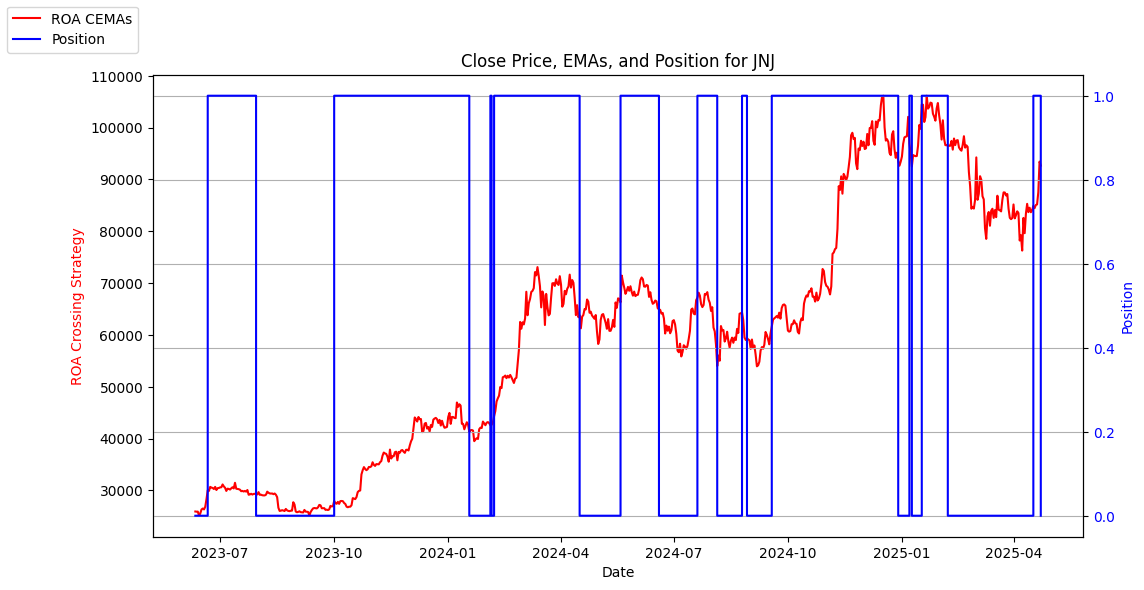

In [54]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df.index, df['close'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

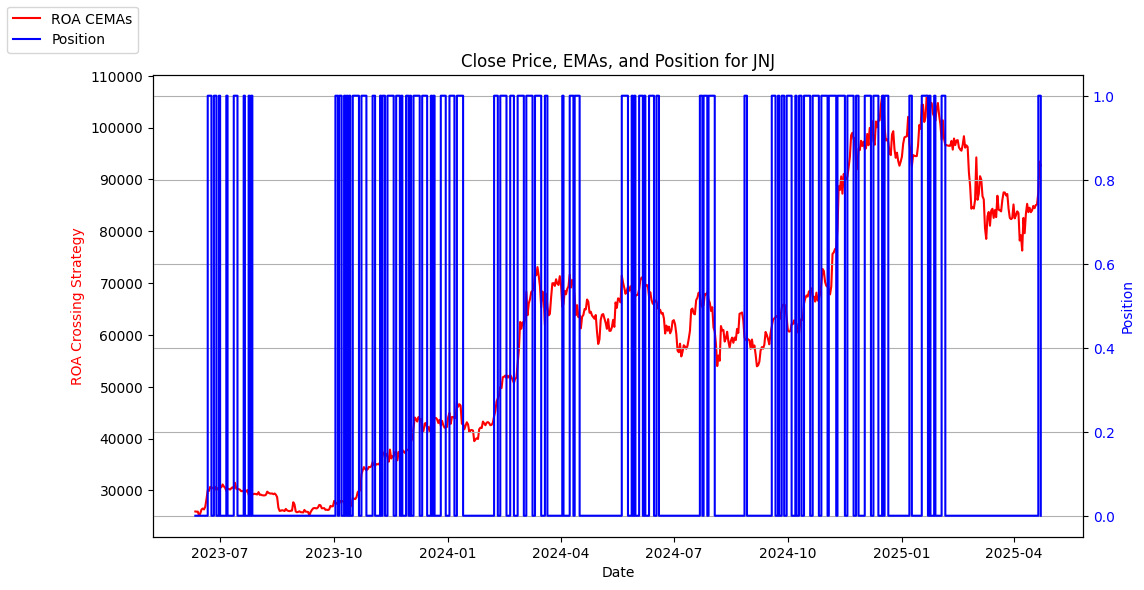

In [55]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#ROA strategy
ax1.plot(dfv.index, dfv['close'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(dfv.index, dfv['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

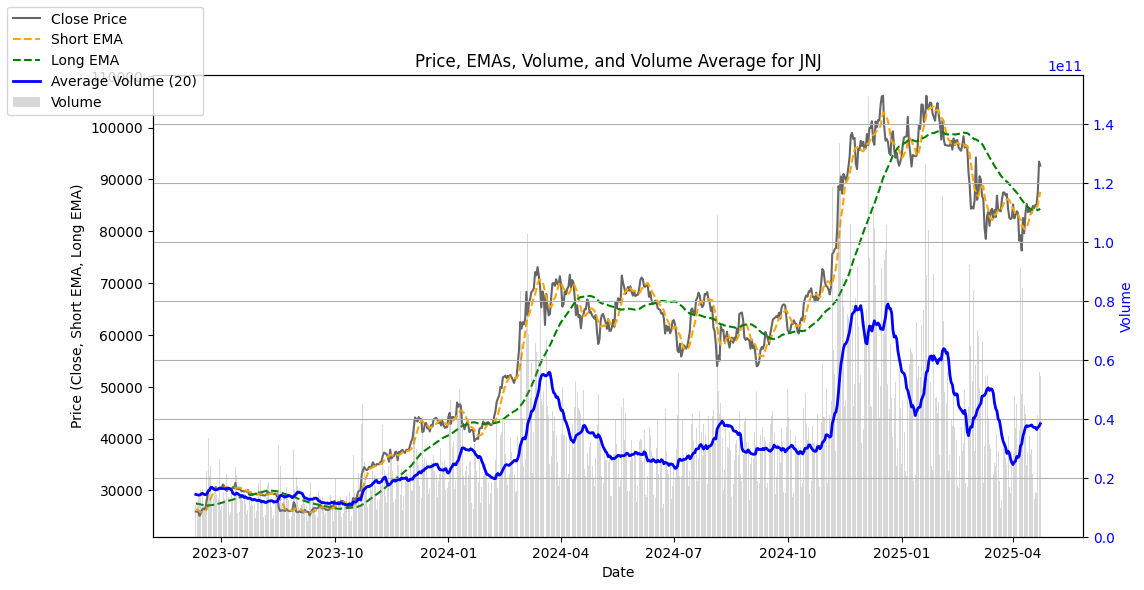

In [49]:
import matplotlib.pyplot as plt

# Create a 1x1 grid for the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Left Plot: Close Price, Short & Long EMAs ---
ax1.plot(dfv.index, dfv['close'], label='Close Price', color='black', alpha=0.6)
ax1.plot(dfv.index, dfv['shortEMA'], label='Short EMA', color='orange', linestyle='--')
ax1.plot(dfv.index, dfv['longEMA'], label='Long EMA', color='green', linestyle='--')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (Close, Short EMA, Long EMA)', color='black')
ax1.tick_params('y', labelcolor='black')

# --- Right Plot: Volume and Volume Average ---
ax2 = ax1.twinx()  # Create a second y-axis
ax2.bar(dfv.index, dfv['volume'], label='Volume', color='gray', alpha=0.3, width=0.8)  # Bar plot for volume
ax2.plot(dfv.index, dfv['avg_volume'], label='Average Volume (20)', color='blue', linestyle='-', linewidth=2)
ax2.set_ylabel('Volume', color='blue')
ax2.tick_params('y', labelcolor='blue')

# Set title
plt.title('Price, EMAs, Volume, and Volume Average for JNJ')

# Adding legends for both plots
fig.legend(loc='upper left')

# Show grid and plot
plt.grid(True)
plt.show()


In [31]:
df = compute_strategy_returns(df, slippage_pct, transaction_cost_pct)

df.dropna(inplace=True)


In [32]:
dfv.volume_filter

,volume_filter
Date,
2023-11-09,True
2023-11-10,True
2023-11-11,False
2023-11-12,False
2023-11-13,True
...,...
2025-04-19,False
2025-04-20,False
2025-04-21,True


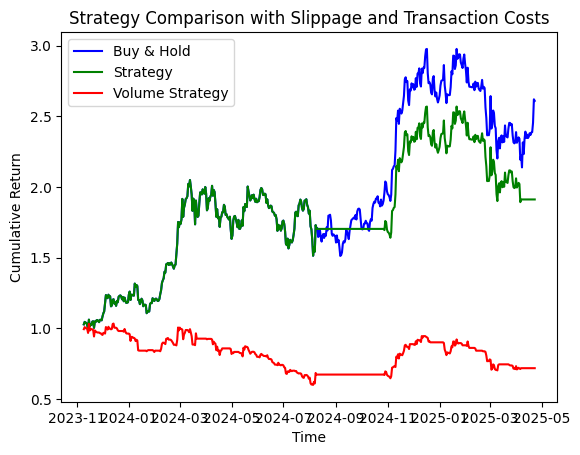

In [33]:
plt.plot(df['cumulative_bnh'], label='Buy & Hold', color='blue')
plt.plot(df['cumulative_strategy'], label='Strategy', color='green')
plt.plot(dfv['cumulative_strategy'], label='Volume Strategy', color='red')


plt.title("Strategy Comparison with Slippage and Transaction Costs")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left')
plt.show()


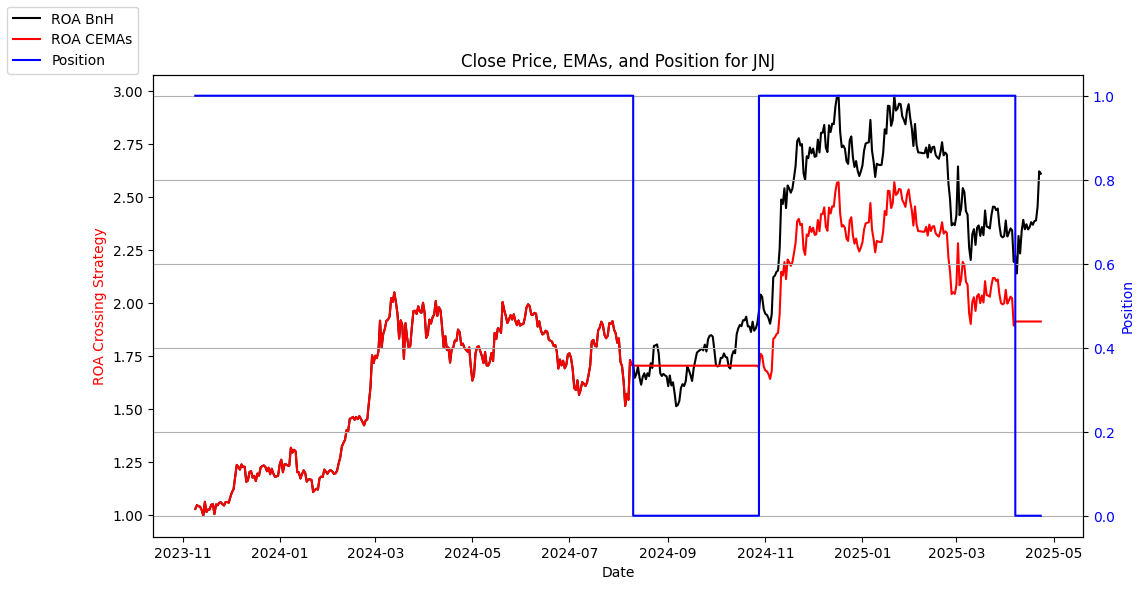

In [27]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#ROA buy n hold
ax1.plot(df.index, df['cumulative_bnh'], label='ROA BnH', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Buy & Hold', color='black')
ax1.tick_params('y', labelcolor='black')
#ROA strategy
ax1.plot(df.index, df['cumulative_strategy'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

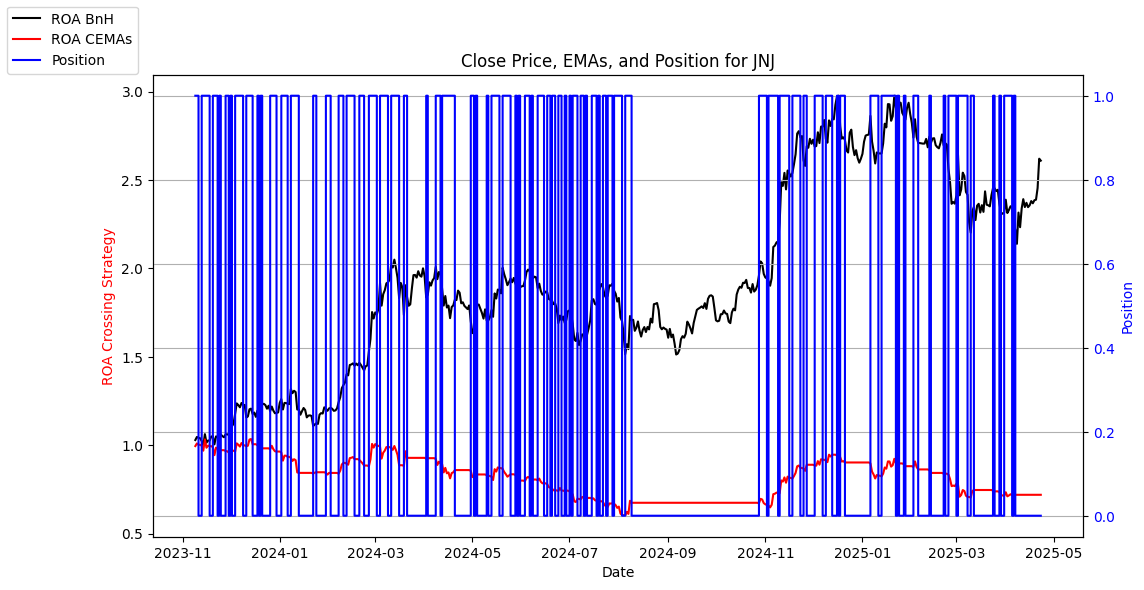

In [34]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#ROA buy n hold
ax1.plot(dfv.index, dfv['cumulative_bnh'], label='ROA BnH', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Buy & Hold', color='black')
ax1.tick_params('y', labelcolor='black')
#ROA strategy
ax1.plot(dfv.index, dfv['cumulative_strategy'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(dfv.index, dfv['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

In [15]:
df['signal'] = df['position'].diff()
dfv['signal'] = dfv['position'].diff()

print("Simple strategy entries:", (df['signal'] == 1).sum())
print("With volume filter entries:", (dfv['signal'] == 1).sum())

Simple strategy entries: 1
With volume filter entries: 67


Price,signal,position,volume_filter
Date,,,
2023-12-01,1.0,1,True
2023-12-04,1.0,1,True
2023-12-11,1.0,1,True
2023-12-18,1.0,1,True
2023-12-20,1.0,1,True
...,...,...,...
2025-03-10,1.0,1,True
2025-03-24,1.0,1,True
2025-03-28,1.0,1,True


In [20]:
df[df['signal'] == 1][['signal','position']]

Price,signal,position
Date,,
2024-10-28,1.0,1
